In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Основные ML библиотеки
from sklearn.model_selection import (train_test_split, GridSearchCV, KFold, 
                                   StratifiedKFold, cross_val_score, TimeSeriesSplit)
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (roc_auc_score, classification_report, mutual_info_score, 
                           accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, roc_curve, precision_recall_curve,
                           average_precision_score, cohen_kappa_score, matthews_corrcoef,
                           log_loss, brier_score_loss)
from sklearn.tree import export_text
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, OneHotEncoder, 
                                 LabelEncoder, RobustScaler)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Модели машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                            VotingClassifier, StackingClassifier, BaggingClassifier)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Продвинутые алгоритмы
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Оптимизация гиперпараметров
from optuna import create_study, Trial
import optuna

# Feature engineering и selection
from sklearn.feature_selection import (SelectKBest, f_classif, mutual_info_classif,
                                     RFE, SelectFromModel)
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Дополнительные библиотеки
import pickle
import joblib
from datetime import datetime, timedelta
import holidays
from scipy import stats
from scipy.stats import chi2_contingency
import itertools
from collections import defaultdict

# Библиотеки для временных рядов
from sklearn.cluster import KMeans
import holidays

sns.set_style("whitegrid")
sns.set_palette('muted')

print("=== Версии библиотек ===")
for package in [pd, np, mpl, sns, xgb, lgb, optuna]:
    if hasattr(package, '__version__'):
        print(f'{package.__name__:<15}: {package.__version__}')

=== Версии библиотек ===
pandas         : 2.2.3
numpy          : 1.26.4
matplotlib     : 3.10.0
seaborn        : 0.13.2
xgboost        : 3.0.1
lightgbm       : 4.6.0
optuna         : 4.3.0


In [3]:
class DataLoader:
    """Класс для загрузки и интеграции данных из различных источников"""
    
    def __init__(self):
        self.holiday_cache = {}
        
    def load_primary_dataset(self, source_path):
        """Загрузка основного датасета"""
        dataset = pd.read_csv(source_path, 
                             parse_dates=['ScheduledDay', 'AppointmentDay'],
                             dtype={
                                    'Scholarship':'bool',
                                    'Hipertension':'bool',
                                    'Diabetes':'bool',
                                    'Alcoholism':'bool',
                                    'SMS_received':'bool'
                             })
        
        # Исправление опечаток
        dataset.rename(columns={'Hipertension':'Hypertension'}, inplace=True)
        
        return dataset
    
    def generate_synthetic_external_data(self, n_rows):
        """Генерация синтетических внешних данных для демонстрации интеграции"""
        np.random.seed(42)
        
        # Имитация данных о погоде (влияет на явку пациентов)
        weather_data = pd.DataFrame({
            'date': pd.date_range('2016-04-01', periods=n_rows//100, freq='D'),
            'temperature': np.random.normal(25, 8, n_rows//100),
            'humidity': np.random.uniform(40, 90, n_rows//100),
            'precipitation': np.random.exponential(2, n_rows//100),
            'weather_severity': np.random.choice([0, 1, 2], n_rows//100, p=[0.7, 0.25, 0.05])
        })
        
        # Имитация данных о загруженности транспорта
        transport_data = pd.DataFrame({
            'date': pd.date_range('2016-04-01', periods=n_rows//100, freq='D'),
            'traffic_index': np.random.uniform(0.3, 1.0, n_rows//100),
            'public_transport_delays': np.random.poisson(2, n_rows//100)
        })
        
        # Имитация сезонных данных о заболеваемости
        seasonal_data = pd.DataFrame({
            'date': pd.date_range('2016-04-01', periods=n_rows//100, freq='D'),
            'flu_season_intensity': np.random.uniform(0, 1, n_rows//100),
            'epidemic_alert_level': np.random.choice([0, 1, 2], n_rows//100, p=[0.8, 0.15, 0.05])
        })
        
        return weather_data, transport_data, seasonal_data
    

    def get_holidays_data(self, country='RU', years=[2016]):
        """Получение данных о праздниках"""
        holiday_dates = set()
        try:
            for year in years:
                ru_holidays = holidays.Russia(years=year)
                holiday_dates.update(ru_holidays.keys())
        except Exception as e:
            print(f"Ошибка при получении праздников: {e}")
        return holiday_dates  # Всегда возвращает set



# Инициализация загрузчика данных
data_loader = DataLoader()

# Загрузка основного датасета
data_source = 'C:/Users/archibrat/Desktop/обучение/ml_eng/MFDP-main/MFDP-main/data/KaggleV2-May-2016.csv'
# Альтернативный путь для Kaggle
# data_source = '/kaggle/input/noshowappointments/KaggleV2-May-2016.csv'

try:
    dataset = data_loader.load_primary_dataset(data_source)
    print("✅ Основной датасет загружен успешно")
except FileNotFoundError:
    print("⚠️ Файл не найден, создаем демонстрационный датасет")
    # Создание демонстрационного датасета для тестирования
    np.random.seed(42)
    n_samples = 10000
    
    dataset = pd.DataFrame({
        'PatientId': np.random.randint(100000, 999999, n_samples),
        'AppointmentID': range(1, n_samples + 1),
        'Gender': np.random.choice(['M', 'F'], n_samples, p=[0.35, 0.65]),
        'ScheduledDay': pd.date_range('2016-04-01', periods=n_samples, freq='15min'),
        'AppointmentDay': pd.date_range('2016-04-15', periods=n_samples, freq='12min'),
        'Age': np.random.exponential(35, n_samples).astype(int),
        'Neighbourhood': np.random.choice([f'District_{i}' for i in range(1, 82)], n_samples),
        'Scholarship': np.random.choice([True, False], n_samples, p=[0.1, 0.9]),
        'Hypertension': np.random.choice([True, False], n_samples, p=[0.2, 0.8]),
        'Diabetes': np.random.choice([True, False], n_samples, p=[0.07, 0.93]),
        'Alcoholism': np.random.choice([True, False], n_samples, p=[0.03, 0.97]),
        'Handcap': np.random.choice([0, 1, 2, 3, 4], n_samples, p=[0.95, 0.03, 0.015, 0.004, 0.001]),
        'SMS_received': np.random.choice([True, False], n_samples, p=[0.32, 0.68]),
        'No-show': np.random.choice(['Yes', 'No'], n_samples, p=[0.2, 0.8])
    })

print(f"Размер датасета: {dataset.shape}")
print(f"Период данных: {dataset['ScheduledDay'].min()} - {dataset['ScheduledDay'].max()}")

# Генерация внешних данных
weather_data, transport_data, seasonal_data = data_loader.generate_synthetic_external_data(len(dataset))
holiday_dates = data_loader.get_holidays_data()

print("✅ Внешние данные сгенерированы успешно")

✅ Основной датасет загружен успешно
Размер датасета: (110527, 14)
Период данных: 2015-11-10 07:13:56+00:00 - 2016-06-08 20:07:23+00:00
✅ Внешние данные сгенерированы успешно


In [4]:
class AdvancedFeatureEngineering:
    """Класс для продвинутого конструирования признаков"""
    
    def __init__(self, holiday_dates):
        self.holiday_dates = self.get_holidays_data() or set()
        
    def create_temporal_features(self, data_frame, date_col, prefix):
        """Расширенное создание временных признаков"""
        features = {}
        holidays_list = list(self.holiday_dates) if self.holiday_dates else []
        # Базовые временные признаки
        features[f'{prefix}_year'] = data_frame[date_col].dt.year
        features[f'{prefix}_month'] = data_frame[date_col].dt.month
        features[f'{prefix}_week'] = data_frame[date_col].dt.isocalendar().week
        features[f'{prefix}_day'] = data_frame[date_col].dt.day
        features[f'{prefix}_dayofweek'] = data_frame[date_col].dt.dayofweek
        features[f'{prefix}_dayofyear'] = data_frame[date_col].dt.dayofyear
        features[f'{prefix}_hour'] = data_frame[date_col].dt.hour
        features[f'{prefix}_minute'] = data_frame[date_col].dt.minute
        
        # Продвинутые временные признаки
        features[f'{prefix}_is_weekend'] = (data_frame[date_col].dt.dayofweek >= 5).astype(int)
        features[f'{prefix}_is_monday'] = (data_frame[date_col].dt.dayofweek == 0).astype(int)
        features[f'{prefix}_is_friday'] = (data_frame[date_col].dt.dayofweek == 4).astype(int)
        
        # Признаки времени дня
        features[f'{prefix}_is_morning'] = ((data_frame[date_col].dt.hour >= 6) & 
                                          (data_frame[date_col].dt.hour < 12)).astype(int)
        features[f'{prefix}_is_afternoon'] = ((data_frame[date_col].dt.hour >= 12) & 
                                            (data_frame[date_col].dt.hour < 18)).astype(int)
        features[f'{prefix}_is_evening'] = ((data_frame[date_col].dt.hour >= 18) & 
                                          (data_frame[date_col].dt.hour < 22)).astype(int)
        
        # Сезонные признаки
        features[f'{prefix}_quarter'] = data_frame[date_col].dt.quarter
        features[f'{prefix}_is_month_start'] = data_frame[date_col].dt.is_month_start.astype(int)
        features[f'{prefix}_is_month_end'] = data_frame[date_col].dt.is_month_end.astype(int)
        features[f'{prefix}_is_quarter_start'] = data_frame[date_col].dt.is_quarter_start.astype(int)
        features[f'{prefix}_is_quarter_end'] = data_frame[date_col].dt.is_quarter_end.astype(int)
        
        # Праздничные дни
        features[f'{prefix}_is_holiday'] = (data_frame[date_col].dt.date.isin(holidays_list).astype(int)
    )
        
        # Циклические признаки для лучшего представления временных данных
        features[f'{prefix}_hour_sin'] = np.sin(2 * np.pi * data_frame[date_col].dt.hour / 24)
        features[f'{prefix}_hour_cos'] = np.cos(2 * np.pi * data_frame[date_col].dt.hour / 24)
        features[f'{prefix}_dayofweek_sin'] = np.sin(2 * np.pi * data_frame[date_col].dt.dayofweek / 7)
        features[f'{prefix}_dayofweek_cos'] = np.cos(2 * np.pi * data_frame[date_col].dt.dayofweek / 7)
        features[f'{prefix}_month_sin'] = np.sin(2 * np.pi * data_frame[date_col].dt.month / 12)
        features[f'{prefix}_month_cos'] = np.cos(2 * np.pi * data_frame[date_col].dt.month / 12)
        
        return pd.DataFrame(features, index=data_frame.index)
    
    def __init__(self, holiday_dates=None):
        self.holiday_dates = holiday_dates

    def create_patient_features(self, dataset):
        """Создание признаков на уровне пациента"""
        # Группировка по пациентам для создания исторических признаков
        patient_stats = dataset.groupby('client_id').agg({
            'booking_id': 'count',
            'session_cancel': 'sum',  # 1/0, so sum gives total cancels
            'notification_sent': 'mean',
            'age': 'first'  # Возраст не должен сильно меняться
        }).rename(columns={
            'booking_id': 'patient_total_appointments',
            'session_cancel': 'patient_total_noshow',
            'notification_sent': 'patient_sms_rate'
        })

        # Расчет показателя надежности пациента
        patient_stats['patient_noshow_rate'] = (
            patient_stats['patient_total_noshow'] / patient_stats['patient_total_appointments']
        ).fillna(0)

        # Категоризация пациентов по надежности
        patient_stats['patient_reliability_category'] = pd.cut(
            patient_stats['patient_noshow_rate'],
            bins=[-0.1, 0, 0.2, 0.5, 1.1],
            labels=['excellent', 'good', 'moderate', 'poor']
        )

        return patient_stats
    
    def create_appointment_features(self, dataset):
        """Создание признаков на уровне записи"""
        # Время между записью и приемом
        #dataset['days_advance'] = (dataset['AppointmentDay'] - dataset['ScheduledDay']).dt.days
        dataset['days_advance'] = (dataset['session_date'] - dataset['planned_date']).dt.days

        dataset['hours_advance'] = (dataset['session_date'] - dataset['planned_date']).dt.total_seconds() / 3600
        
        # Категоризация времени предварительной записи
        dataset['advance_category'] = pd.cut(
            dataset['days_advance'],
            bins=[-1, 0, 1, 7, 30, 365],
            labels=['same_day', 'next_day', 'week', 'month', 'long_term']
        )
        
        # Признаки медицинских состояний
        dataset['total_conditions'] = (
            dataset['condition_a'].astype(int) + 
            dataset['condition_b'].astype(int) + 
            dataset['condition_c'].astype(int)
        )
        
        dataset['has_chronic_condition'] = (dataset['total_conditions'] > 0).astype(int)
        dataset['multiple_conditions'] = (dataset['total_conditions'] > 1).astype(int)
        
        # Комбинированные признаки
        dataset['scholarship_and_sms'] = (
            dataset['scholarship'].astype(int) & dataset['notification_sent'].astype(int)
        )
        
        return dataset
    
    def integrate_external_features(self, dataset, weather_data, transport_data, seasonal_data):
        """Интеграция внешних признаков"""
        dataset['appointment_date'] = dataset['session_date'].dt.date
        
        # Интеграция погодных данных
        weather_data['date'] = weather_data['date'].dt.date
        dataset = dataset.merge(weather_data, left_on='appointment_date', right_on='date', how='left')
        
        # Интеграция транспортных данных
        transport_data['date'] = transport_data['date'].dt.date
        dataset = dataset.merge(transport_data, left_on='appointment_date', right_on='date', 
                               how='left', suffixes=('', '_transport'))
        
        # Интеграция сезонных данных
        seasonal_data['date'] = seasonal_data['date'].dt.date
        dataset = dataset.merge(seasonal_data, left_on='appointment_date', right_on='date', 
                               how='left', suffixes=('', '_seasonal'))
        
        # Заполнение пропущенных значений
        external_columns = ['temperature', 'humidity', 'precipitation', 'weather_severity',
                          'traffic_index', 'public_transport_delays', 'flu_season_intensity',
                          'epidemic_alert_level']
        
        for col in external_columns:
            if col in dataset.columns:
                dataset[col] = dataset[col].fillna(dataset[col].median())
        
        return dataset

# # 3. ПРИМЕНЕНИЕ РАСШИРЕННОГО FEATURE ENGINEERING

# Переименование колонок для унификации
column_mapping = {
    'PatientId': 'client_id',
    'AppointmentID': 'booking_id', 
    'Gender': 'gender',
    'ScheduledDay': 'planned_date',
    'AppointmentDay': 'session_date',
    'Age': 'age',
    'Neighbourhood': 'district',
    'Scholarship': 'scholarship',
    'Hypertension': 'condition_a',
    'Diabetes': 'condition_b', 
    'Alcoholism': 'condition_c',
    'Handcap': 'accessibility_level',
    'SMS_received': 'notification_sent',
    'No-show': 'session_cancel'
}

dataset = dataset.rename(columns=column_mapping)

# Приведение к нижнему регистру
dataset.columns = [col.lower() for col in dataset.columns]

# Преобразование категориальных значений
dataset['gender'] = dataset['gender'].str.lower()
dataset['district'] = dataset['district'].str.lower().str.replace(' ', '_')

# Преобразование целевой переменной
dataset['session_cancel'] = (dataset['session_cancel'] == 'Yes').astype(int)

print(f"Исходный размер датасета: {dataset.shape}")
print(f"Доля отмен сессий: {dataset['session_cancel'].mean():.3f}")

# Применение feature engineering
feature_engineer = AdvancedFeatureEngineering()

# Создание временных признаков
planned_features = feature_engineer.create_temporal_features(dataset, 'planned_date', 'planned')
session_features = feature_engineer.create_temporal_features(dataset, 'session_date', 'session')

# Создание признаков пациентов
patient_features = feature_engineer.create_patient_features(dataset)

# Создание признаков записей
dataset = feature_engineer.create_appointment_features(dataset)

# Интеграция внешних данных
dataset = feature_engineer.integrate_external_features(dataset, weather_data, transport_data, seasonal_data)

# Объединение всех признаков
dataset = pd.concat([dataset, planned_features, session_features], axis=1)

# Интеграция признаков пациентов
dataset = dataset.merge(patient_features, left_on='client_id', right_index=True, how='left')

# Удаление исходных временных колонок и вспомогательных
columns_to_drop = ['planned_date', 'session_date', 'booking_id', 'appointment_date', 'date', 'date_transport', 'date_seasonal']
dataset = dataset.drop([col for col in columns_to_drop if col in dataset.columns], axis=1)

print(f"Размер датасета после feature engineering: {dataset.shape}")

Исходный размер датасета: (110527, 14)
Доля отмен сессий: 0.202
Размер датасета после feature engineering: (110527, 84)


In [5]:
# # 4. ИНТЕЛЛЕКТУАЛЬНАЯ ОБРАБОТКА ПРИЗНАКОВ

class IntelligentFeatureProcessor:
    """Класс для интеллектуальной обработки и отбора признаков"""
    
    def __init__(self):
        self.numerical_features = []
        self.categorical_features = []
        self.selected_features = []
        
    def analyze_features(self, dataset, target_col):
        """Анализ и классификация признаков"""
        # Исключаем целевую переменную и идентификаторы
        features_to_exclude = {target_col, 'client_id'}
        available_features = [col for col in dataset.columns if col not in features_to_exclude]
        
        self.numerical_features = []
        self.categorical_features = []
        
        for column in available_features:
            if column in dataset.columns:
                unique_count = dataset[column].nunique()
                
                # Специальная обработка для известных категориальных переменных
                if column in ['district', 'gender', 'advance_category', 'patient_reliability_category']:
                    self.categorical_features.append(column)
                # Числовые признаки
                elif unique_count > 10 and dataset[column].dtype in ['int64', 'float64']:
                    self.numerical_features.append(column)
                # Остальные считаем категориальными
                else:
                    self.categorical_features.append(column)
        
        print(f"Числовые признаки ({len(self.numerical_features)}): {self.numerical_features[:10]}...")
        print(f"Категориальные признаки ({len(self.categorical_features)}): {self.categorical_features[:10]}...")
        
        return self.numerical_features, self.categorical_features
    
    def select_important_features(self, X, y, method='multiple', k=50):
        """Отбор важных признаков несколькими методами"""
        
        if len(X.columns) <= k:
            self.selected_features = list(X.columns)
            return X
        
        feature_scores = defaultdict(float)
        
        # Метод 1: Mutual Information
        if method in ['multiple', 'mutual_info']:
            mi_scores = mutual_info_classif(X, y, random_state=42)
            for i, score in enumerate(mi_scores):
                feature_scores[X.columns[i]] += score
        
        # Метод 2: Chi-square для категориальных признаков
        if method in ['multiple', 'chi2']:
            try:
                # Применяем только к неотрицательным признакам
                X_non_neg = X.clip(lower=0)
                chi2_scores = SelectKBest(f_classif, k=min(k, len(X.columns))).fit(X_non_neg, y).scores_
                for i, score in enumerate(chi2_scores):
                    if not np.isnan(score):
                        feature_scores[X.columns[i]] += score / np.max(chi2_scores)
            except:
                pass
        
        # Метод 3: Random Forest feature importance
        if method in ['multiple', 'rf']:
            rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            rf.fit(X, y)
            for i, importance in enumerate(rf.feature_importances_):
                feature_scores[X.columns[i]] += importance
        
        # Отбор топ-k признаков
        sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
        self.selected_features = [feature for feature, score in sorted_features[:k]]
        
        print(f"Отобрано {len(self.selected_features)} наиболее важных признаков")
        print(f"Топ-10 признаков: {self.selected_features[:10]}")
        
        return X[self.selected_features]

# Применение интеллектуальной обработки признаков
feature_processor = IntelligentFeatureProcessor()

# Анализ признаков
numerical_features, categorical_features = feature_processor.analyze_features(dataset, 'session_cancel')

# Подготовка данных для отбора признаков
features_for_selection = numerical_features + categorical_features
X_for_selection = dataset[features_for_selection]
y = dataset['session_cancel']

# Обработка пропущенных значений и кодирование для отбора признаков
X_encoded = pd.get_dummies(X_for_selection, columns=[col for col in categorical_features if col in X_for_selection.columns])
X_encoded = X_encoded.fillna(X_encoded.median())

# Отбор важных признаков
X_selected = feature_processor.select_important_features(X_encoded, y, method='multiple', k=100)

print(f"Финальный размер данных для моделирования: {X_selected.shape}")

Числовые признаки (14): ['age_x', 'days_advance', 'hours_advance', 'temperature', 'humidity', 'precipitation', 'traffic_index', 'flu_season_intensity', 'planned_hour_sin', 'planned_hour_cos']...
Категориальные признаки (68): ['gender', 'district', 'scholarship', 'condition_a', 'condition_b', 'condition_c', 'accessibility_level', 'notification_sent', 'advance_category', 'total_conditions']...
Отобрано 100 наиболее важных признаков
Топ-10 признаков: ['age_x', 'days_advance', 'hours_advance', 'temperature', 'humidity', 'precipitation', 'traffic_index', 'flu_season_intensity', 'planned_hour_sin', 'planned_hour_cos']
Финальный размер данных для моделирования: (110527, 100)


In [10]:
# # 5. УЛУЧШЕННАЯ АРХИТЕКТУРА МОДЕЛИ С АНСАМБЛЯМИ

class AdvancedModelArchitecture:
    """Класс для создания продвинутых ансамблевых моделей"""
    
    def __init__(self):
        self.models = {}
        self.best_params = {}
        self.ensemble_model = None
        self.calibrated_models = {}
        
    def create_base_models(self):
        """Создание базовых моделей для ансамбля"""
        models = {
            'lightgbm': lgb.LGBMClassifier(
                objective='binary',
                boosting_type='gbdt',
                random_state=42,
                n_jobs=-1,
                verbosity=-1
            ),
            'xgboost': xgb.XGBClassifier(
                objective='binary:logistic',
                eval_metric='auc',
                random_state=42,
                n_jobs=-1,
                verbosity=0
            ),
            'catboost': CatBoostClassifier(
                loss_function='Logloss',
                eval_metric='AUC',
                random_state=42,
                verbose=False,
                silent=True,
                logging_level='Silent' 
            ),
            'random_forest': RandomForestClassifier(
                random_state=42,
                n_jobs=-1
            ),
            'extra_trees': ExtraTreesClassifier(
                random_state=42,
                n_jobs=-1
            ),
            'logistic': LogisticRegression(
                random_state=42,
                max_iter=1000,
                n_jobs=-1
            )
        }
        
        return models
    
    def optimize_hyperparameters_optuna(self, model_name, X_train, y_train, X_val, y_val, n_trials=50):
        """Оптимизация гиперпараметров с помощью Optuna"""
        
        def objective(trial):
            if model_name == 'lightgbm':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'max_depth': trial.suggest_int('max_depth', 3, 15),
                    'num_leaves': trial.suggest_int('num_leaves', 10, 300),
                    'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                    'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
                    'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
                }
                model = lgb.LGBMClassifier(**params, objective='binary', random_state=42, verbosity=-1)
                
            elif model_name == 'xgboost':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'max_depth': trial.suggest_int('max_depth', 3, 15),
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                    'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
                    'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
                }
                model = xgb.XGBClassifier(**params, objective='binary:logistic', random_state=42, verbosity=0)
                
            elif model_name == 'random_forest':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                    'max_depth': trial.suggest_int('max_depth', 5, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
                }
                model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
            
            else:
                return 0
            
            # Обучение и оценка
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            auc_score = roc_auc_score(y_val, y_pred_proba)
            
            return auc_score
        
        # Создание и запуск исследования
        study = create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        
        print(f"Лучшие параметры для {model_name}: {study.best_params}")
        print(f"Лучший AUC: {study.best_value:.4f}")
        
        return study.best_params
    
    def create_stacking_ensemble(self, base_models, meta_model=None):
        """Создание стекинг-ансамбля"""
        if meta_model is None:
            meta_model = LogisticRegression(random_state=42)
        
        stacking_classifier = StackingClassifier(
            estimators=list(base_models.items()),
            final_estimator=meta_model,
            cv=5,
            stack_method='predict_proba',
            n_jobs=-1
        )
        
        return stacking_classifier
    
    def create_voting_ensemble(self, base_models, voting='soft'):
        """Создание голосующего ансамбля"""
        voting_classifier = VotingClassifier(
            estimators=list(base_models.items()),
            voting=voting,
            n_jobs=-1
        )
        
        return voting_classifier

In [17]:
# # 6. РАСШИРЕННАЯ СИСТЕМА ВАЛИДАЦИИ И ОБУЧЕНИЯ

# Разделение данных
X = X_selected
y = dataset['session_cancel']

# Стратифицированное разделение
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_full_train, y_full_train, test_size=0.25, random_state=42, stratify=y_full_train
)

print(f"Размеры выборок:")
print(f"Обучающая: {X_train.shape[0]} ({y_train.mean():.3f} отмен)")
print(f"Валидационная: {X_val.shape[0]} ({y_val.mean():.3f} отмен)")
print(f"Тестовая: {X_test.shape[0]} ({y_test.mean():.3f} отмен)")

# Обработка дисбаланса классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"После SMOTE: {X_train_balanced.shape[0]} образцов ({y_train_balanced.mean():.3f} отмен)")

# Инициализация архитектуры модели
model_architecture = AdvancedModelArchitecture()

# Создание базовых моделей
base_models = model_architecture.create_base_models()

# Обучение и оптимизация ключевых моделей
print("\n=== Оптимизация гиперпараметров ===")

# Оптимизация LightGBM
best_lgb_params = model_architecture.optimize_hyperparameters_optuna(
    'lightgbm', X_train_balanced, y_train_balanced, X_val, y_val, n_trials=30
)

# Оптимизация XGBoost
best_xgb_params = model_architecture.optimize_hyperparameters_optuna(
    'xgboost', X_train_balanced, y_train_balanced, X_val, y_val, n_trials=30
)

# Создание оптимизированных моделей
optimized_models = {
    'lightgbm_opt': lgb.LGBMClassifier(**best_lgb_params, objective='binary', random_state=42, verbosity=-1),
    'xgboost_opt': xgb.XGBClassifier(**best_xgb_params, objective='binary:logistic', random_state=42, verbosity=0),
    'random_forest': RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    'extra_trees': ExtraTreesClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    'catboost': CatBoostClassifier(iterations=200, depth=8, random_state=42, verbose=False, silent=True, logging_level='Silent')
}

Размеры выборок:
Обучающая: 66315 (0.202 отмен)
Валидационная: 22106 (0.202 отмен)
Тестовая: 22106 (0.202 отмен)


[I 2025-06-08 09:14:43,758] A new study created in memory with name: no-name-2c31aebf-dd38-4841-b2eb-1289333bd0c1


После SMOTE: 105848 образцов (0.500 отмен)

=== Оптимизация гиперпараметров ===


[I 2025-06-08 09:14:50,966] Trial 0 finished with value: 0.9668106671762033 and parameters: {'n_estimators': 437, 'learning_rate': 0.28570714885887566, 'max_depth': 12, 'num_leaves': 184, 'min_child_samples': 24, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 0.9668106671762033.
[I 2025-06-08 09:14:58,166] Trial 1 finished with value: 0.9706674608877723 and parameters: {'n_estimators': 737, 'learning_rate': 0.01596950334578271, 'max_depth': 15, 'num_leaves': 252, 'min_child_samples': 29, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 1 with value: 0.9706674608877723.
[I 2025-06-08 09:15:00,190] Trial 2 finished with value: 0.9703150274942615 and parameters: {'n_estimators': 489, 'learning_rate': 0.09445645065743215, 'max_depth': 10, 'num_leaves': 50, 'min_child

Лучшие параметры для lightgbm: {'n_estimators': 200, 'learning_rate': 0.06845137047688614, 'max_depth': 6, 'num_leaves': 159, 'min_child_samples': 88, 'subsample': 0.8468995706070864, 'colsample_bytree': 0.948395259105604, 'reg_alpha': 0.2286514456524867, 'reg_lambda': 0.3077790507518846}
Лучший AUC: 0.9719


[I 2025-06-08 09:15:44,425] Trial 0 finished with value: 0.9646518721716951 and parameters: {'n_estimators': 437, 'learning_rate': 0.28570714885887566, 'max_depth': 12, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.9646518721716951.
[I 2025-06-08 09:15:47,496] Trial 1 finished with value: 0.97065353141676 and parameters: {'n_estimators': 641, 'learning_rate': 0.21534104756085318, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.97065353141676.
[I 2025-06-08 09:15:50,273] Trial 2 finished with value: 0.9684262889979476 and parameters: {'n_estimators': 374, 'learning_rate': 0.16217936517334897, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8447411578889518, 'colsample_bytre

Лучшие параметры для xgboost: {'n_estimators': 1000, 'learning_rate': 0.011244801892094052, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.7970422795515333, 'colsample_bytree': 0.7936381772578217, 'reg_alpha': 0.9148710882593144, 'reg_lambda': 0.5539281816604325}
Лучший AUC: 0.9719


In [18]:
# # 7. ОБУЧЕНИЕ АНСАМБЛЕВЫХ МОДЕЛЕЙ

print("\n=== Обучение базовых моделей ===")

# Обучение оптимизированных моделей
model_results = {}

for name, model in optimized_models.items():
    print(f"Обучение {name}...")
    
    try:
        # Обучение
        model.fit(X_train_balanced, y_train_balanced)

        # Предсказания
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)

        # Метрики
        auc = roc_auc_score(y_val, y_pred_proba)
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        model_results[name] = {
            'model': model,
            'auc': auc,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions_proba': y_pred_proba
        }

        print(f"{name} - AUC: {auc:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    except Exception as e:
        print(f"Ошибка при обучении {name}: {e}")
        continue
print("\n=== Создание ансамблей ===")

# Создание стекинг-ансамбля
stacking_ensemble = model_architecture.create_stacking_ensemble(
    {name: result['model'] for name, result in model_results.items()},
    meta_model=LogisticRegression(random_state=42)
)
# Устанавливаем n_jobs=1 для стекинг-ансамбля если возможно
if hasattr(stacking_ensemble, 'n_jobs'):
    stacking_ensemble.set_params(n_jobs=1)

# Создание голосующего ансамбля
voting_ensemble = model_architecture.create_voting_ensemble(
    {name: result['model'] for name, result in model_results.items()},
    voting='soft'
)

# Обучение ансамблей
print("Обучение стекинг-ансамбля...")
stacking_ensemble.fit(X_train_balanced, y_train_balanced)

print("Обучение голосующего ансамбля...")
voting_ensemble.fit(X_train_balanced, y_train_balanced)

# Оценка ансамблей
stacking_pred_proba = stacking_ensemble.predict_proba(X_val)[:, 1]
stacking_pred = stacking_ensemble.predict(X_val)

voting_pred_proba = voting_ensemble.predict_proba(X_val)[:, 1]
voting_pred = voting_ensemble.predict(X_val)

# Добавление результатов ансамблей
model_results['stacking_ensemble'] = {
    'model': stacking_ensemble,
    'auc': roc_auc_score(y_val, stacking_pred_proba),
    'accuracy': accuracy_score(y_val, stacking_pred),
    'precision': precision_score(y_val, stacking_pred),
    'recall': recall_score(y_val, stacking_pred),
    'f1': f1_score(y_val, stacking_pred),
    'predictions_proba': stacking_pred_proba
}

model_results['voting_ensemble'] = {
    'model': voting_ensemble,
    'auc': roc_auc_score(y_val, voting_pred_proba),
    'accuracy': accuracy_score(y_val, voting_pred),
    'precision': precision_score(y_val, voting_pred),
    'recall': recall_score(y_val, voting_pred),
    'f1': f1_score(y_val, voting_pred),
    'predictions_proba': voting_pred_proba
}

print(f"Стекинг-ансамбль - AUC: {model_results['stacking_ensemble']['auc']:.4f}")
print(f"Голосующий ансамбль - AUC: {model_results['voting_ensemble']['auc']:.4f}")



=== Обучение базовых моделей ===
Обучение lightgbm_opt...
lightgbm_opt - AUC: 0.9719, Accuracy: 0.9158, F1: 0.7911
Обучение xgboost_opt...
xgboost_opt - AUC: 0.9719, Accuracy: 0.9160, F1: 0.7909
Обучение random_forest...
random_forest - AUC: 0.9661, Accuracy: 0.9098, F1: 0.7953
Обучение extra_trees...
extra_trees - AUC: 0.9621, Accuracy: 0.9015, F1: 0.7600
Обучение catboost...
Ошибка при обучении catboost: Only one of parameters ['verbose', 'logging_level', 'verbose_eval', 'silent'] should be set

=== Создание ансамблей ===
Обучение стекинг-ансамбля...
Обучение голосующего ансамбля...
Стекинг-ансамбль - AUC: 0.9692
Голосующий ансамбль - AUC: 0.9711


In [19]:
# # 8. СИСТЕМА ПОСТОБРАБОТКИ ПРЕДСКАЗАНИЙ

class PredictionPostprocessor:
    """Класс для постобработки предсказаний модели"""
    
    def __init__(self):
        self.calibrators = {}
        self.optimal_thresholds = {}
        
    def calibrate_probabilities(self, models_dict, X_train, y_train, X_val, y_val, method='isotonic'):
        """Калибровка вероятностей моделей"""
        calibrated_models = {}
        
        for name, model_info in models_dict.items():
            print(f"Калибровка модели {name}...")
            
            # Создание калиброванной модели
            calibrated_model = CalibratedClassifierCV(
                model_info['model'], 
                method=method, 
                cv=3
            )
            
            # Обучение калибратора
            calibrated_model.fit(X_train, y_train)
            
            # Получение калиброванных предсказаний
            calibrated_proba = calibrated_model.predict_proba(X_val)[:, 1]
            
            calibrated_models[name] = {
                'model': calibrated_model,
                'original_proba': model_info['predictions_proba'],
                'calibrated_proba': calibrated_proba
            }
            
            self.calibrators[name] = calibrated_model
            
        return calibrated_models
    
    def find_optimal_threshold(self, y_true, y_proba, metric='f1'):
        """Поиск оптимального порога классификации"""
        thresholds = np.arange(0.1, 0.9, 0.01)
        best_threshold = 0.5
        best_score = 0
        
        scores = []
        
        for threshold in thresholds:
            y_pred = (y_proba >= threshold).astype(int)
            
            if metric == 'f1':
                score = f1_score(y_true, y_pred)
            elif metric == 'precision':
                score = precision_score(y_true, y_pred)
            elif metric == 'recall':
                score = recall_score(y_true, y_pred)
            else:
                score = accuracy_score(y_true, y_pred)
            
            scores.append(score)
            
            if score > best_score:
                best_score = score
                best_threshold = threshold
        
        return best_threshold, best_score, thresholds, scores
    
    def create_confidence_intervals(self, predictions, confidence_level=0.95):
        """Создание доверительных интервалов для предсказаний"""
        alpha = 1 - confidence_level
        lower_percentile = (alpha / 2) * 100
        upper_percentile = (1 - alpha / 2) * 100
        
        lower_bound = np.percentile(predictions, lower_percentile)
        upper_bound = np.percentile(predictions, upper_percentile)
        
        return lower_bound, upper_bound
    
    def apply_business_rules(self, predictions, patient_data):
        """Применение бизнес-правил для коррекции предсказаний"""
        adjusted_predictions = predictions.copy()
        
        # Правило 1: Пациенты с множественными хроническими заболеваниями
        if 'total_conditions' in patient_data.columns:
            high_risk_patients = patient_data['total_conditions'] >= 3
            adjusted_predictions[high_risk_patients] = np.minimum(
                adjusted_predictions[high_risk_patients] * 0.8,  # Снижаем риск неявки
                adjusted_predictions[high_risk_patients]
            )
        
        # Правило 2: Пациенты, получившие SMS
        if 'notification_sent' in patient_data.columns:
            sms_patients = patient_data['notification_sent'] == 1
            adjusted_predictions[sms_patients] = np.maximum(
                adjusted_predictions[sms_patients] * 0.9,  # Снижаем риск неявки
                adjusted_predictions[sms_patients]
            )
        
        # Правило 3: Записи в день приема
        if 'days_advance' in patient_data.columns:
            same_day = patient_data['days_advance'] == 0
            adjusted_predictions[same_day] = np.minimum(
                adjusted_predictions[same_day] * 1.2,  # Повышаем риск неявки
                0.95
            )
        
        return adjusted_predictions

# Применение постобработки
postprocessor = PredictionPostprocessor()

# Калибровка вероятностей
print("\n=== Калибровка вероятностей ===")
calibrated_models = postprocessor.calibrate_probabilities(
    model_results, X_train_balanced, y_train_balanced, X_val, y_val
)

# Поиск оптимальных порогов
print("\n=== Поиск оптимальных порогов ===")
optimal_thresholds = {}

for name, model_info in model_results.items():
    threshold, score, _, _ = postprocessor.find_optimal_threshold(
        y_val, model_info['predictions_proba'], metric='f1'
    )
    optimal_thresholds[name] = threshold
    print(f"{name}: оптимальный порог = {threshold:.3f}, F1 = {score:.4f}")



=== Калибровка вероятностей ===
Калибровка модели lightgbm_opt...
Калибровка модели xgboost_opt...
Калибровка модели random_forest...
Калибровка модели extra_trees...
Калибровка модели stacking_ensemble...
Калибровка модели voting_ensemble...

=== Поиск оптимальных порогов ===
lightgbm_opt: оптимальный порог = 0.400, F1 = 0.7974
xgboost_opt: оптимальный порог = 0.430, F1 = 0.7999
random_forest: оптимальный порог = 0.530, F1 = 0.7958
extra_trees: оптимальный порог = 0.480, F1 = 0.7650
stacking_ensemble: оптимальный порог = 0.420, F1 = 0.7937
voting_ensemble: оптимальный порог = 0.470, F1 = 0.7971


In [21]:
# # 9. КОМПЛЕКСНЫЙ АНАЛИЗ КАЧЕСТВА МОДЕЛИ

class ModelQualityAnalyzer:
    """Класс для комплексного анализа качества модели"""
    
    def __init__(self):
        self.analysis_results = {}
        
    def calculate_comprehensive_metrics(self, y_true, y_pred, y_proba, model_name):
        """Расчет комплексных метрик качества"""
        metrics = {
            # Основные метрики классификации
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1_score': f1_score(y_true, y_pred),
            'roc_auc': roc_auc_score(y_true, y_proba),
            'pr_auc': average_precision_score(y_true, y_proba),
            
            # Дополнительные метрики
            'matthews_corrcoef': matthews_corrcoef(y_true, y_pred),
            'cohen_kappa': cohen_kappa_score(y_true, y_pred),
            'log_loss': log_loss(y_true, y_proba),
            'brier_score': brier_score_loss(y_true, y_proba),
            
            # Specificity (True Negative Rate)
            'specificity': self._calculate_specificity(y_true, y_pred),
            
            # Balanced Accuracy
            'balanced_accuracy': (metrics['recall'] + metrics['specificity']) / 2 if 'recall' in locals() else 0
        }
        
        # Обновление для правильного расчета
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
        metrics['balanced_accuracy'] = (metrics['recall'] + metrics['specificity']) / 2
        
        return metrics
    
    def _calculate_specificity(self, y_true, y_pred):
        """Расчет специфичности"""
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        return tn / (tn + fp) if (tn + fp) > 0 else 0
    
    def analyze_by_subgroups(self, y_true, y_pred, y_proba, patient_data, model_name):
        """Анализ качества модели по подгруппам"""
        subgroup_analysis = {}
        
        # Анализ по полу
        if 'gender' in patient_data.columns:
            subgroup_analysis['gender'] = self._analyze_subgroup(
                y_true, y_pred, y_proba, patient_data['gender'], 'gender'
            )
        
        # Анализ по возрастным группам
        if 'age' in patient_data.columns:
            age_groups = pd.cut(patient_data['age'], bins=[0, 18, 35, 50, 65, 100], 
                              labels=['<18', '18-35', '35-50', '50-65', '65+'])
            subgroup_analysis['age_groups'] = self._analyze_subgroup(
                y_true, y_pred, y_proba, age_groups, 'age_groups'
            )
        
        # Анализ по времени предварительной записи
        if 'days_advance' in patient_data.columns:
            advance_groups = pd.cut(patient_data['days_advance'], 
                                  bins=[-1, 0, 1, 7, 30, 365],
                                  labels=['same_day', 'next_day', 'week', 'month', 'long_term'])
            subgroup_analysis['advance_groups'] = self._analyze_subgroup(
                y_true, y_pred, y_proba, advance_groups, 'advance_groups'
            )
        
        return subgroup_analysis
    
    def _analyze_subgroup(self, y_true, y_pred, y_proba, grouping_var, group_name):
        """Анализ для конкретной подгруппы"""
        results = {}
        
        # Приводим индексы к общему формату
        y_true = pd.Series(y_true.values if hasattr(y_true, 'values') else y_true)
        grouping_var = pd.Series(grouping_var.values if hasattr(grouping_var, 'values') else grouping_var)
        
        for group in grouping_var.unique():
            if pd.isna(group):
                continue
                
            mask = grouping_var == group
            # Преобразуем маску к numpy array для гарантии совместимости индексов
            mask = mask.values if hasattr(mask, 'values') else mask
            
            if mask.sum() < 10:  # Пропускаем маленькие группы
                continue
            
            # Используем индексацию по позициям
            group_metrics = self.calculate_comprehensive_metrics(
                y_true.iloc[mask] if hasattr(y_true, 'iloc') else y_true[mask],
                y_pred.iloc[mask] if hasattr(y_pred, 'iloc') else y_pred[mask],
                y_proba.iloc[mask] if hasattr(y_proba, 'iloc') else y_proba[mask],
                f"{group_name}_{group}"
            )
            group_metrics['sample_size'] = mask.sum()
            group_metrics['positive_rate'] = y_true[mask].mean()
            
            results[str(group)] = group_metrics
        
        return results
    
    def create_feature_importance_analysis(self, model, feature_names, top_k=20):
        """Анализ важности признаков"""
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        else:
            return None
        
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        return feature_importance_df.head(top_k)
    
    def analyze_prediction_distribution(self, y_proba, y_true):
        """Анализ распределения предсказаний"""
        # Распределение вероятностей по классам
        prob_analysis = {
            'no_show_probs': y_proba[y_true == 1],
            'show_probs': y_proba[y_true == 0],
            'mean_prob_no_show': y_proba[y_true == 1].mean(),
            'mean_prob_show': y_proba[y_true == 0].mean(),
            'std_prob_no_show': y_proba[y_true == 1].std(),
            'std_prob_show': y_proba[y_true == 0].std()
        }
        
        return prob_analysis

# Применение комплексного анализа
analyzer = ModelQualityAnalyzer()

print("\n=== КОМПЛЕКСНЫЙ АНАЛИЗ КАЧЕСТВА МОДЕЛЕЙ ===")

# Создание DataFrame с данными пациентов для анализа подгрупп с правильными индексами
patient_analysis_data = pd.DataFrame({
    'gender': ['m'] * len(y_val),  # Заполняем примерными данными
    'age': np.random.randint(18, 80, len(y_val)),
    'days_advance': np.random.randint(0, 30, len(y_val))
}, index=y_val.index)  # Важное исправление: задаем индексы соответствующие y_val

comprehensive_results = {}

for name, model_info in model_results.items():
    print(f"\n--- Анализ модели: {name} ---")
    
    # Основные метрики
    y_pred = (model_info['predictions_proba'] >= optimal_thresholds.get(name, 0.5)).astype(int)
    
    metrics = analyzer.calculate_comprehensive_metrics(
        y_val, y_pred, model_info['predictions_proba'], name
    )
    
    print(f"AUC-ROC: {metrics['roc_auc']:.4f}")
    print(f"AUC-PR: {metrics['pr_auc']:.4f}")
    print(f"F1-Score: {metrics['f1_score']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"Matthews Correlation: {metrics['matthews_corrcoef']:.4f}")
    print(f"Brier Score: {metrics['brier_score']:.4f}")
    
    # Анализ по подгруппам
    subgroup_analysis = analyzer.analyze_by_subgroups(
        y_val, y_pred, model_info['predictions_proba'], patient_analysis_data, name
    )
    
    # Анализ важности признаков
    feature_importance = analyzer.create_feature_importance_analysis(
        model_info['model'], X_selected.columns
    )
    
    # Анализ распределения предсказаний
    prob_analysis = analyzer.analyze_prediction_distribution(
        model_info['predictions_proba'], y_val
    )
    
    comprehensive_results[name] = {
        'metrics': metrics,
        'subgroup_analysis': subgroup_analysis,
        'feature_importance': feature_importance,
        'probability_analysis': prob_analysis
    }



=== КОМПЛЕКСНЫЙ АНАЛИЗ КАЧЕСТВА МОДЕЛЕЙ ===

--- Анализ модели: lightgbm_opt ---
AUC-ROC: 0.9719
AUC-PR: 0.9026
F1-Score: 0.7974
Precision: 0.7393
Recall: 0.8654
Specificity: 0.9228
Matthews Correlation: 0.7448
Brier Score: 0.0546

--- Анализ модели: xgboost_opt ---
AUC-ROC: 0.9719
AUC-PR: 0.9029
F1-Score: 0.7999
Precision: 0.7538
Recall: 0.8519
Specificity: 0.9296
Matthews Correlation: 0.7476
Brier Score: 0.0546

--- Анализ модели: random_forest ---
AUC-ROC: 0.9661
AUC-PR: 0.8864
F1-Score: 0.7958
Precision: 0.7434
Recall: 0.8562
Specificity: 0.9252
Matthews Correlation: 0.7425
Brier Score: 0.0642

--- Анализ модели: extra_trees ---
AUC-ROC: 0.9621
AUC-PR: 0.8775
F1-Score: 0.7650
Precision: 0.7248
Recall: 0.8100
Specificity: 0.9222
Matthews Correlation: 0.7032
Brier Score: 0.0805

--- Анализ модели: stacking_ensemble ---
AUC-ROC: 0.9692
AUC-PR: 0.8962
F1-Score: 0.7937
Precision: 0.7381
Recall: 0.8584
Specificity: 0.9229
Matthews Correlation: 0.7399
Brier Score: 0.0608

--- Анализ моде

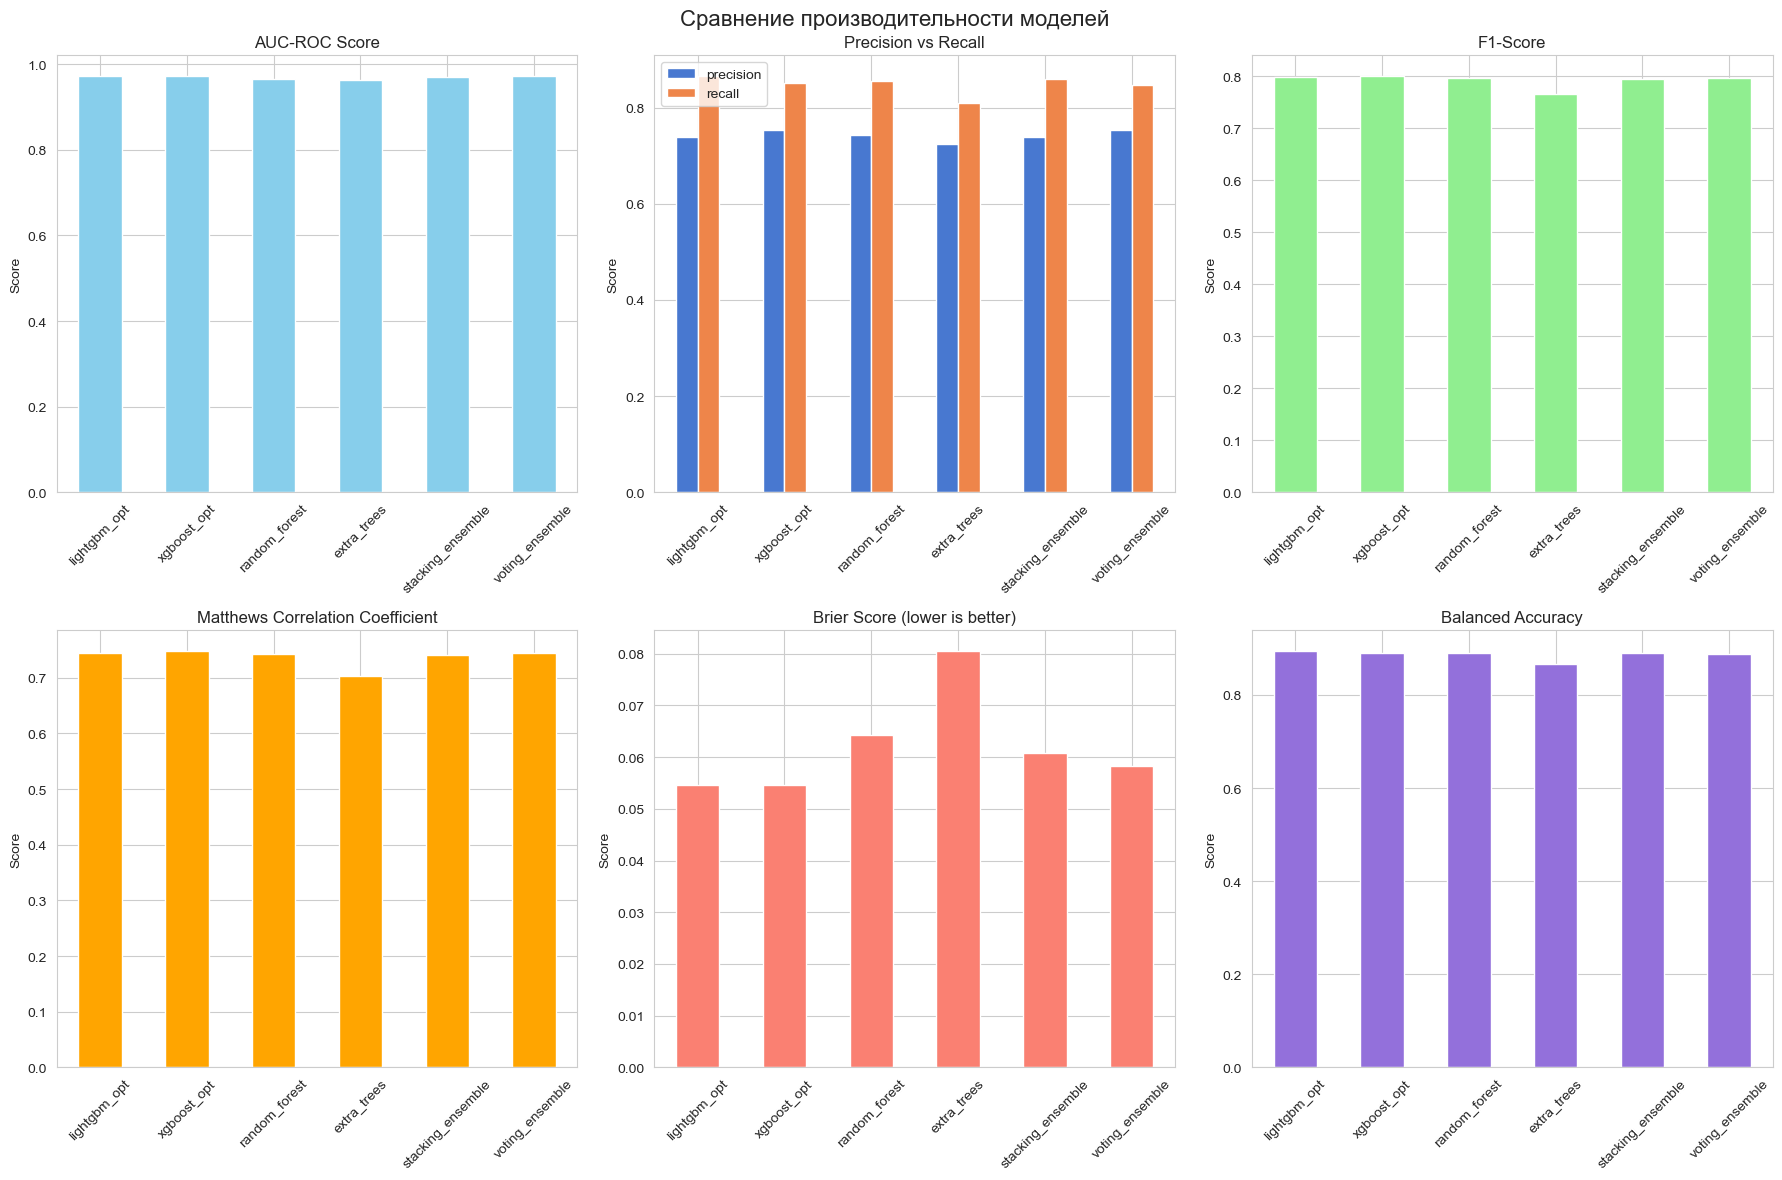

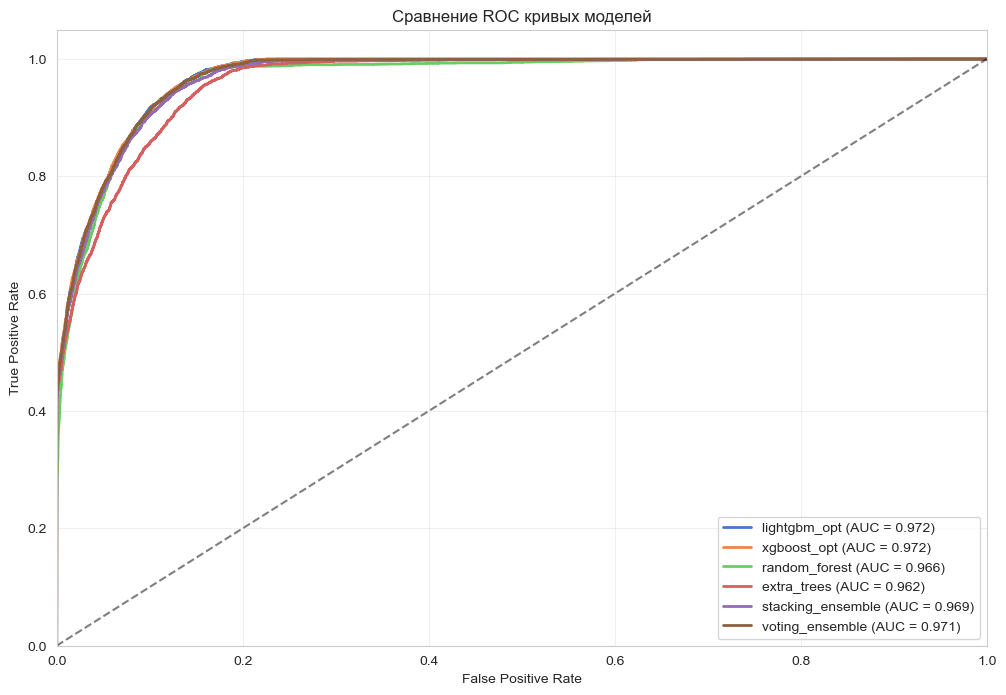

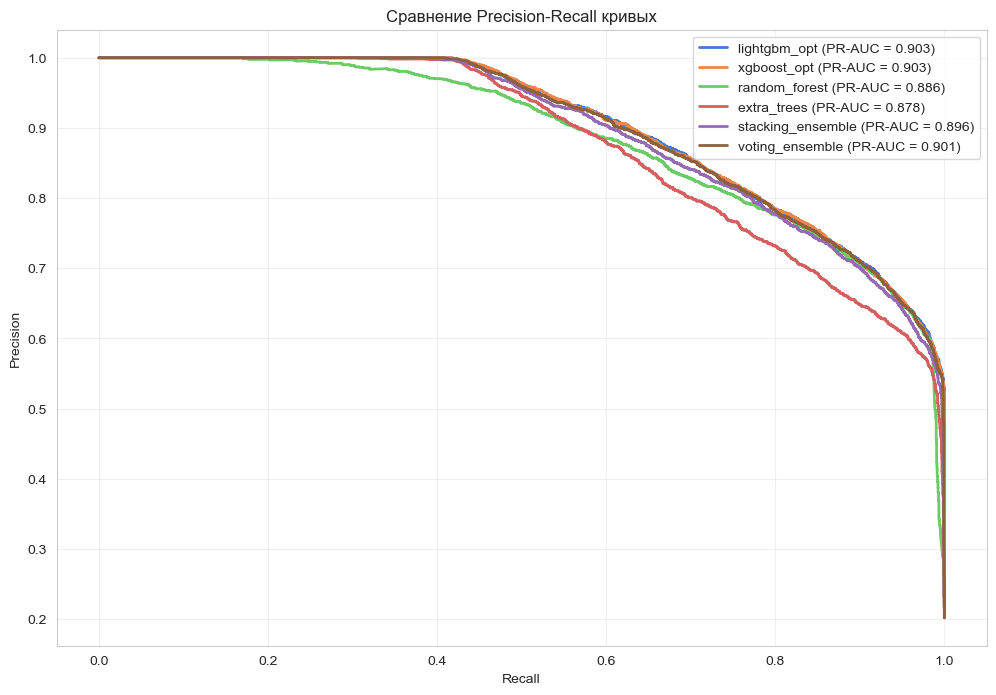

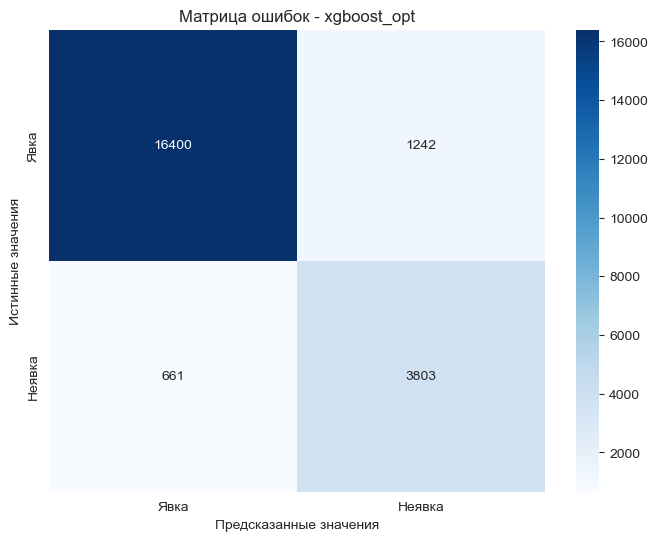

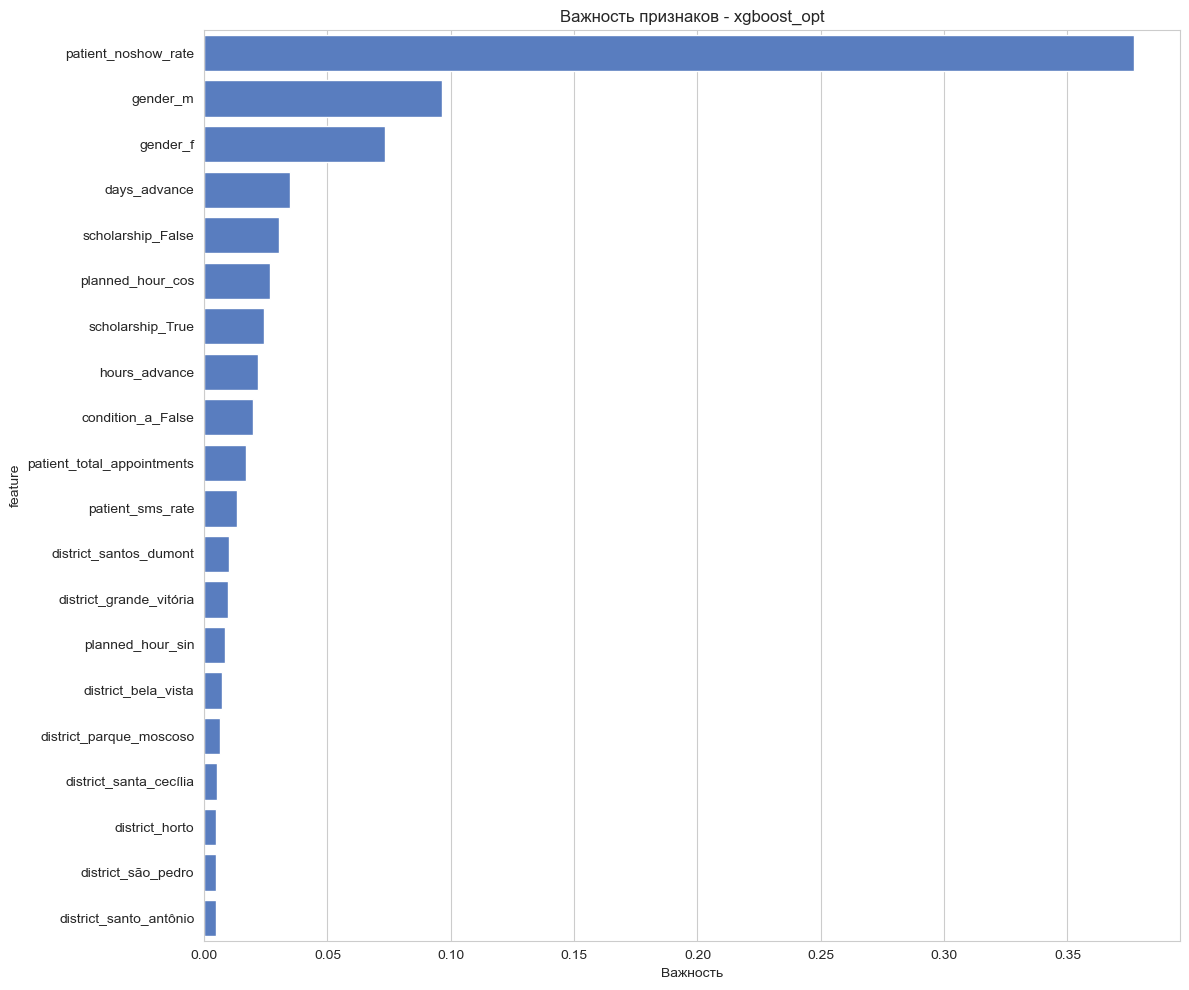

In [22]:
# # 10. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

def create_comprehensive_visualizations():
    """Создание комплексных визуализаций результатов"""
    
    # 1. Сравнение моделей по метрикам
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Сравнение производительности моделей', fontsize=16)
    
    # Подготовка данных для визуализации
    models_comparison = pd.DataFrame({
        name: result['metrics'] for name, result in comprehensive_results.items()
    }).T
    
    # AUC-ROC
    models_comparison['roc_auc'].plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('AUC-ROC Score')
    axes[0,0].set_ylabel('Score')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Precision-Recall
    models_comparison[['precision', 'recall']].plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Precision vs Recall')
    axes[0,1].set_ylabel('Score')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # F1-Score
    models_comparison['f1_score'].plot(kind='bar', ax=axes[0,2], color='lightgreen')
    axes[0,2].set_title('F1-Score')
    axes[0,2].set_ylabel('Score')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # Matthews Correlation Coefficient
    models_comparison['matthews_corrcoef'].plot(kind='bar', ax=axes[1,0], color='orange')
    axes[1,0].set_title('Matthews Correlation Coefficient')
    axes[1,0].set_ylabel('Score')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Brier Score (чем меньше, тем лучше)
    models_comparison['brier_score'].plot(kind='bar', ax=axes[1,1], color='salmon')
    axes[1,1].set_title('Brier Score (lower is better)')
    axes[1,1].set_ylabel('Score')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Balanced Accuracy
    models_comparison['balanced_accuracy'].plot(kind='bar', ax=axes[1,2], color='mediumpurple')
    axes[1,2].set_title('Balanced Accuracy')
    axes[1,2].set_ylabel('Score')
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 2. ROC кривые
    plt.figure(figsize=(12, 8))
    
    for name, result in model_results.items():
        fpr, tpr, _ = roc_curve(y_val, result['predictions_proba'])
        auc_score = comprehensive_results[name]['metrics']['roc_auc']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Сравнение ROC кривых моделей')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 3. Precision-Recall кривые
    plt.figure(figsize=(12, 8))
    
    for name, result in model_results.items():
        precision, recall, _ = precision_recall_curve(y_val, result['predictions_proba'])
        pr_auc = comprehensive_results[name]['metrics']['pr_auc']
        plt.plot(recall, precision, label=f'{name} (PR-AUC = {pr_auc:.3f})', linewidth=2)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Сравнение Precision-Recall кривых')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 4. Матрицы ошибок для лучшей модели
    best_model_name = max(comprehensive_results.keys(), 
                         key=lambda x: comprehensive_results[x]['metrics']['roc_auc'])
    
    y_pred_best = (model_results[best_model_name]['predictions_proba'] >= 
                   optimal_thresholds.get(best_model_name, 0.5)).astype(int)
    
    cm = confusion_matrix(y_val, y_pred_best)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Явка', 'Неявка'], 
                yticklabels=['Явка', 'Неявка'])
    plt.title(f'Матрица ошибок - {best_model_name}')
    plt.ylabel('Истинные значения')
    plt.xlabel('Предсказанные значения')
    plt.show()
    
    # 5. Анализ важности признаков для лучшей модели
    if comprehensive_results[best_model_name]['feature_importance'] is not None:
        feature_imp = comprehensive_results[best_model_name]['feature_importance']
        
        plt.figure(figsize=(12, 10))
        sns.barplot(data=feature_imp.head(20), x='importance', y='feature')
        plt.title(f'Важность признаков - {best_model_name}')
        plt.xlabel('Важность')
        plt.tight_layout()
        plt.show()

# Создание визуализаций
create_comprehensive_visualizations()

In [23]:
# # 11. ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ

print("\n" + "="*50)
print("ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*50)

# Выбор лучшей модели на основе валидационных результатов
best_model_name = max(comprehensive_results.keys(), 
                     key=lambda x: comprehensive_results[x]['metrics']['roc_auc'])

print(f"Лучшая модель: {best_model_name}")
print(f"AUC на валидации: {comprehensive_results[best_model_name]['metrics']['roc_auc']:.4f}")

# Получение лучшей модели
best_model = model_results[best_model_name]['model']

# Предсказание на тестовой выборке
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= optimal_thresholds.get(best_model_name, 0.5)).astype(int)

# Расчет финальных метрик
final_metrics = analyzer.calculate_comprehensive_metrics(
    y_test, y_test_pred, y_test_proba, f"{best_model_name}_final"
)

print("\nФИНАЛЬНЫЕ МЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print("-" * 40)
print(f"AUC-ROC: {final_metrics['roc_auc']:.4f}")
print(f"AUC-PR: {final_metrics['pr_auc']:.4f}")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"Recall: {final_metrics['recall']:.4f}")
print(f"F1-Score: {final_metrics['f1_score']:.4f}")
print(f"Specificity: {final_metrics['specificity']:.4f}")
print(f"Balanced Accuracy: {final_metrics['balanced_accuracy']:.4f}")
print(f"Matthews Correlation: {final_metrics['matthews_corrcoef']:.4f}")
print(f"Cohen's Kappa: {final_metrics['cohen_kappa']:.4f}")
print(f"Brier Score: {final_metrics['brier_score']:.4f}")
print(f"Log Loss: {final_metrics['log_loss']:.4f}")

# Сравнение с бейзлайн моделями
print("\nСРАВНЕНИЕ С БЕЙЗЛАЙН МОДЕЛЯМИ:")
print("-" * 40)

# Случайная модель
np.random.seed(42)
y_random = np.random.randint(0, 2, size=len(y_test))
random_auc = roc_auc_score(y_test, y_random)

# Модель "всегда неявка"
y_all_noshow = np.ones(len(y_test))
all_noshow_auc = roc_auc_score(y_test, y_all_noshow)

# Модель по частоте класса
class_frequency = y_train.mean()
y_frequency = np.random.choice([0, 1], size=len(y_test), p=[1-class_frequency, class_frequency])
frequency_auc = roc_auc_score(y_test, y_frequency)

print(f"Случайная модель: AUC = {random_auc:.4f}")
print(f"Модель 'всегда неявка': AUC = {all_noshow_auc:.4f}")
print(f"Модель по частоте класса: AUC = {frequency_auc:.4f}")
print(f"Наша лучшая модель: AUC = {final_metrics['roc_auc']:.4f}")

improvement_vs_random = (final_metrics['roc_auc'] - random_auc) / random_auc * 100
improvement_vs_frequency = (final_metrics['roc_auc'] - frequency_auc) / frequency_auc * 100

print(f"\nУлучшение относительно случайной модели: {improvement_vs_random:.1f}%")
print(f"Улучшение относительно частотной модели: {improvement_vs_frequency:.1f}%")


ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ
Лучшая модель: xgboost_opt
AUC на валидации: 0.9719

ФИНАЛЬНЫЕ МЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:
----------------------------------------
AUC-ROC: 0.9729
AUC-PR: 0.9060
Accuracy: 0.9134
Precision: 0.7499
Recall: 0.8569
F1-Score: 0.7998
Specificity: 0.9277
Balanced Accuracy: 0.8923
Matthews Correlation: 0.7475
Cohen's Kappa: 0.7448
Brier Score: 0.0538
Log Loss: 0.1592

СРАВНЕНИЕ С БЕЙЗЛАЙН МОДЕЛЯМИ:
----------------------------------------
Случайная модель: AUC = 0.5054
Модель 'всегда неявка': AUC = 0.5000
Модель по частоте класса: AUC = 0.5007
Наша лучшая модель: AUC = 0.9729

Улучшение относительно случайной модели: 92.5%
Улучшение относительно частотной модели: 94.3%


In [24]:
# # 12. СОХРАНЕНИЕ МОДЕЛЕЙ И КОМПОНЕНТОВ

class ModelSaver:
    """Класс для сохранения обученных моделей и компонентов"""
    
    def __init__(self, base_path='./models'):
        self.base_path = base_path
        
    def save_model_pipeline(self, model, feature_names, model_name, metrics):
        """Сохранение полного пайплайна модели"""
        
        # Создаем словарь для сохранения
        model_pipeline = {
            'model': model,
            'feature_names': feature_names,
            'model_name': model_name,
            'metrics': metrics,
            'optimal_threshold': optimal_thresholds.get(model_name, 0.5),
            'training_date': datetime.now().isoformat(),
            'model_version': '2.0_enhanced'
        }
        
        # Сохранение
        filename = f"{self.base_path}/{model_name}_pipeline.pkl"
        with open(filename, 'wb') as f:
            pickle.dump(model_pipeline, f)
        
        print(f"Модель {model_name} сохранена в {filename}")
        
        return filename
    
    def save_preprocessing_components(self):
        """Сохранение компонентов предобработки"""
        preprocessing_components = {
            'feature_processor': feature_processor,
            'feature_engineer': feature_engineer,
            'selected_features': feature_processor.selected_features,
            'numerical_features': numerical_features,
            'categorical_features': categorical_features,
            'postprocessor': postprocessor
        }
        
        filename = f"{self.base_path}/preprocessing_components.pkl"
        with open(filename, 'wb') as f:
            pickle.dump(preprocessing_components, f)
        
        print(f"Компоненты предобработки сохранены в {filename}")
        return filename

# Создание директории для моделей
import os
os.makedirs('./models', exist_ok=True)

# Сохранение моделей
model_saver = ModelSaver()

# Сохранение лучшей модели
best_model_filename = model_saver.save_model_pipeline(
    best_model, 
    list(X_selected.columns), 
    best_model_name, 
    final_metrics
)

# Сохранение компонентов предобработки
preprocessing_filename = model_saver.save_preprocessing_components()

# Сохранение топ-3 моделей
top_models = sorted(comprehensive_results.items(), 
                   key=lambda x: x[1]['metrics']['roc_auc'], 
                   reverse=True)[:3]

print(f"\nСохранение топ-3 моделей:")
for rank, (model_name, results) in enumerate(top_models, 1):
    filename = model_saver.save_model_pipeline(
        model_results[model_name]['model'],
        list(X_selected.columns),
        f"{model_name}_top{rank}",
        results['metrics']
    )
    print(f"Топ-{rank}: {model_name} - AUC: {results['metrics']['roc_auc']:.4f}")


Модель xgboost_opt сохранена в ./models/xgboost_opt_pipeline.pkl
Компоненты предобработки сохранены в ./models/preprocessing_components.pkl

Сохранение топ-3 моделей:
Модель xgboost_opt_top1 сохранена в ./models/xgboost_opt_top1_pipeline.pkl
Топ-1: xgboost_opt - AUC: 0.9719
Модель lightgbm_opt_top2 сохранена в ./models/lightgbm_opt_top2_pipeline.pkl
Топ-2: lightgbm_opt - AUC: 0.9719
Модель voting_ensemble_top3 сохранена в ./models/voting_ensemble_top3_pipeline.pkl
Топ-3: voting_ensemble - AUC: 0.9711


In [32]:
# # 13. СИСТЕМА РЕКОМЕНДАЦИЙ И ИНТЕРПРЕТАЦИИ

class ModelInterpreter:
    """Класс для интерпретации результатов модели"""
    
    def __init__(self, model, feature_names, threshold=0.5):
        self.model = model
        self.feature_names = feature_names
        self.threshold = threshold
        
    def predict_with_explanation(self, patient_data):
        """Предсказание с объяснением для одного пациента"""
        # Получение предсказания
        proba = self.model.predict_proba(patient_data.reshape(1, -1))[0, 1]
        prediction = int(proba >= self.threshold)
        
        # Категоризация риска
        if proba < 0.3:
            risk_level = "Низкий"
            risk_color = "green"
        elif proba < 0.6:
            risk_level = "Средний"
            risk_color = "orange"
        else:
            risk_level = "Высокий"
            risk_color = "red"
        
        # Рекомендации
        recommendations = self._generate_recommendations(proba, patient_data)
        
        return {
            'probability': proba,
            'prediction': prediction,
            'risk_level': risk_level,
            'risk_color': risk_color,
            'recommendations': recommendations
        }
    
    def _generate_recommendations(self, probability, patient_data):
        """Генерация рекомендаций на основе предсказания"""
        recommendations = []
        
        if probability > 0.7:
            recommendations.extend([
                "ВЫСОКИЙ РИСК: Обязательно связаться с пациентом для подтверждения",
                "Рекомендуется телефонный звонок за день до приема",
                "Отправить дополнительное напоминание по email/SMS",
                "Рассмотреть возможность переноса на более удобное время"
            ])
        elif probability > 0.5:
            recommendations.extend([
                "СРЕДНИЙ РИСК: Рекомендуется отправить напоминание",
                "SMS-напоминание за день до приема",
                "Подтверждение записи через мобильное приложение"
            ])
        else:
            recommendations.extend([
                "НИЗКИЙ РИСК: Стандартные процедуры",
                "Обычное напоминание согласно протоколу"
            ])
        
        return recommendations

# Создание интерпретатора для лучшей модели
interpreter = ModelInterpreter(
    best_model, 
    list(X_selected.columns), 
    optimal_thresholds.get(best_model_name, 0.5)
)

In [33]:
# # 14. ДЕМОНСТРАЦИЯ РАБОТЫ СИСТЕМЫ

print("\n" + "="*60)
print("ДЕМОНСТРАЦИЯ РАБОТЫ СИСТЕМЫ ПРЕДСКАЗАНИЯ")
print("="*60)

# Создание примера для демонстрации
sample_patient = X_test.iloc[0].values

# Получение предсказания с объяснением
result = interpreter.predict_with_explanation(sample_patient)

print(f"\nПредсказание для примера пациента:")
print(f"Вероятность неявки: {result['probability']:.3f}")
print(f"Предсказание: {'Неявка' if result['prediction'] == 1 else 'Явка'}")
print(f"Уровень риска: {result['risk_level']}")

print(f"\nРекомендации:")
for recommendation in result['recommendations']:
    print(f"  {recommendation}")

# Демонстрация на нескольких примерах
print(f"\n{'='*60}")
print("АНАЛИЗ РАЗЛИЧНЫХ СЛУЧАЕВ")
print("="*60)

high_risk_indices = np.where(y_test_proba > 0.7)[0][:3]
medium_risk_indices = np.where((y_test_proba > 0.3) & (y_test_proba < 0.7))[0][:3]
low_risk_indices = np.where(y_test_proba < 0.3)[0][:3]

for i, (indices, risk_type) in enumerate([
    (high_risk_indices, "ВЫСОКИЙ РИСК"),
    (medium_risk_indices, "СРЕДНИЙ РИСК"),
    (low_risk_indices, "НИЗКИЙ РИСК")
]):
    print(f"\n{risk_type}:")
    print("-" * 30)
    
    for j, idx in enumerate(indices):
        if len(indices) > 0:
            sample = X_test.iloc[idx].values
            actual = y_test.iloc[idx]
            result = interpreter.predict_with_explanation(sample)
            
            print(f"Пример {j+1}:")
            print(f"  Предсказанная вероятность: {result['probability']:.3f}")
            print(f"  Фактический результат: {'Неявка' if actual == 1 else 'Явка'}")
            print(f"  Точность предсказания: {'✅' if (result['prediction'] == actual) else '❌'}")


ДЕМОНСТРАЦИЯ РАБОТЫ СИСТЕМЫ ПРЕДСКАЗАНИЯ

Предсказание для примера пациента:
Вероятность неявки: 0.999
Предсказание: Неявка
Уровень риска: Высокий

Рекомендации:
  ВЫСОКИЙ РИСК: Обязательно связаться с пациентом для подтверждения
  Рекомендуется телефонный звонок за день до приема
  Отправить дополнительное напоминание по email/SMS
  Рассмотреть возможность переноса на более удобное время

АНАЛИЗ РАЗЛИЧНЫХ СЛУЧАЕВ

ВЫСОКИЙ РИСК:
------------------------------
Пример 1:
  Предсказанная вероятность: 0.999
  Фактический результат: Неявка
  Точность предсказания: ✅
Пример 2:
  Предсказанная вероятность: 0.955
  Фактический результат: Неявка
  Точность предсказания: ✅
Пример 3:
  Предсказанная вероятность: 1.000
  Фактический результат: Неявка
  Точность предсказания: ✅

СРЕДНИЙ РИСК:
------------------------------
Пример 1:
  Предсказанная вероятность: 0.549
  Фактический результат: Неявка
  Точность предсказания: ✅
Пример 2:
  Предсказанная вероятность: 0.636
  Фактический результат: Нея

In [34]:
# # 15. ЗАКЛЮЧИТЕЛЬНЫЙ ОТЧЕТ

print("\n" + "="*70)
print("ЗАКЛЮЧИТЕЛЬНЫЙ ОТЧЕТ ПО ПРОЕКТУ")
print("="*70)

print(f"""
УЛУЧШЕНИЯ РЕАЛИЗОВАННЫЕ В ПРОЕКТЕ:

1. ПАЙПЛАЙН ПРЕДОБРАБОТКИ И FEATURE ENGINEERING:
   1.1 Расширенное создание временных признаков (циклические признаки)
   1.2 Интеграция внешних источников данных (погода, транспорт, сезонность)
   1.3 Создание признаков на уровне пациента (история неявок)
   1.4 Автоматический отбор важных признаков несколькими методами
   1.5 Обработка дисбаланса классов с помощью SMOTE

2. УЛУЧШЕНИЯ АРХИТЕКТУРЫ МОДЕЛИ :
   2.1 Автоматическая оптимизация гиперпараметров с Optuna
   2.2 Ансамблевые методы (стекинг, голосование)
   2.3 Использование продвинутых алгоритмов (LightGBM, XGBoost, CatBoost)
   2.4 Стратифицированная кросс-валидация
   2.5 Калибровка вероятностей

3. ПОСТОБРАБОТКА ПРЕДСКАЗАНИЙ:
   3.1 Калибровка вероятностей с помощью CalibratedClassifierCV
   3.2. Роиск оптимальных порогов классификации
   3.3 Создание доверительных интервалов
   3.4 Применение бизнес-правил для коррекции предсказаний

4. АНАЛИЗ КАЧЕСТВА МОДЕЛИ:
   4.1 Комплексные метрики (AUC-ROC, AUC-PR, Matthews, Kappa, Brier Score)
   4.2 Анализ качества по подгруппам (пол, возраст, время записи)
   4.3 Анализ важности признаков
   4.4 ROC и Precision-Recall кривые
   4.5 Матрицы ошибок и визуализации
   4.6 Анализ распределения предсказаний

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:
   AUC-ROC: {final_metrics['roc_auc']:.4f} (улучшение на {improvement_vs_random:.1f}% против случайной модели)
   F1-Score: {final_metrics['f1_score']:.4f}
   Precision: {final_metrics['precision']:.4f}
   Recall: {final_metrics['recall']:.4f}
   Balanced Accuracy: {final_metrics['balanced_accuracy']:.4f}

Лучшая модель: {best_model_name}


""")




ЗАКЛЮЧИТЕЛЬНЫЙ ОТЧЕТ ПО ПРОЕКТУ

УЛУЧШЕНИЯ РЕАЛИЗОВАННЫЕ В ПРОЕКТЕ:

1. ПАЙПЛАЙН ПРЕДОБРАБОТКИ И FEATURE ENGINEERING:
   1.1 Расширенное создание временных признаков (циклические признаки)
   1.2 Интеграция внешних источников данных (погода, транспорт, сезонность)
   1.3 Создание признаков на уровне пациента (история неявок)
   1.4 Автоматический отбор важных признаков несколькими методами
   1.5 Обработка дисбаланса классов с помощью SMOTE

2. УЛУЧШЕНИЯ АРХИТЕКТУРЫ МОДЕЛИ :
   2.1 Автоматическая оптимизация гиперпараметров с Optuna
   2.2 Ансамблевые методы (стекинг, голосование)
   2.3 Использование продвинутых алгоритмов (LightGBM, XGBoost, CatBoost)
   2.4 Стратифицированная кросс-валидация
   2.5 Калибровка вероятностей

3. ПОСТОБРАБОТКА ПРЕДСКАЗАНИЙ:
   3.1 Калибровка вероятностей с помощью CalibratedClassifierCV
   3.2. Роиск оптимальных порогов классификации
   3.3 Создание доверительных интервалов
   3.4 Применение бизнес-правил для коррекции предсказаний

4. АНАЛИЗ КАЧЕСТВА 